<a href="https://colab.research.google.com/github/AlexeyTri/Timeseries/blob/main/3_Holt%2C_Winters%2C_Theil_Wage_ipynb_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import math
import scipy as sc
import matplotlib.pyplot as plt

# Initialized Exponential Smoothing
# x <array Tx1>- pandas time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptationPeriod <int> - length of Adaptation period in timestamps

def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST	

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    # initialization
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = alpha*x[cntr] + (1-alpha)*y  # = y + alpha*(x[cntr]-y) 
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    
    
    l= np.NaN
    b= np.NaN
    
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1]-x[t]
                t0 = np.NaN
                
            l_prev = l    
                        
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))* x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)*(t-t0+1)/(AdaptationPeriod)*(l - l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha* x[t] + (1-alpha)*(l+b)
                b = beta* (l - l_prev) + (1- beta)*b
                # b = beta* (x[t] - l_prev) + (1- beta)*b


        FORECAST[t+h] = l+ b*h
    return FORECAST
	
def AdditiveWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                # looking in the future
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*l # recurrent smoothing of level 
                
        FORECAST[cntr+h] = l + s[cntr+h-(1+h//p)*p]
    return FORECAST


def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
                    
                    
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
            
        FORECAST[cntr+h] = l+b + s[cntr+h - (1+h//p)*p]
    return FORECAST
	
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation
def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

# generate forecast values based on particular algorithm
# h - forecast horizon, each point in historical period will be forecasted with delay = h (h-step ahead)
# ts - <pandas data frame> with timestamps in index, each column contains particular timeseries, all of them will be forecasted independently
# AlgName - <str> name of the function that runs forecasting algorithm 
# AlgTitle <str> - a name of the forecasting algorithm
# step <char> - aggregation method of the original data before forecasting
# ParamsArray <array> - array of parameter set, each component of array defines particular forecasting algorithm
def build_forecast(h, ts, alg_name, alg_title, params_array, step='D'):
      
	FRC_TS = dict()

	for p in params_array:
		frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
		frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
	  
		for cntr in ts.columns:
			frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)

		#         frc_ts.columns = frc_ts.columns+('%s %s' % (alg_title, p))
		FRC_TS['%s %s' % (alg_title, p)] = frc_ts

	return FRC_TS

# draw forecast and original time series
# ts - <pandas data frame> with timestamps in index, each column contains particular timeseries
# frc_ts - <pandas data frame> the same structure as ts, 
# ts_num <int> - column index for which plot shoud be drawn
# alg_title <str> - a name of the forecasting algorithm
def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
	frc_ts.columns = ts.columns+'; '+alg_title
	ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0, marker='o')
	ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
	plt.xlabel("Time ticks")
	plt.ylabel("TS values")
	plt.legend()
	return ax

# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y).abs()

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAPPE(x,y):
    # Mean absolute predicted percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/y.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualitySMAPE(x,y):
    # Symmetric mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAMAXPE(x,y):
    # Mean absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/max(x.abs(), y.max())).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMASE(x,y, init_step=0):
    # Mean absolute scaled error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/(x-x.shift(1)).abs())[init_step:].replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

def qualityWAPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = x.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAPPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = y.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAMAXPE(x,y):
    # Weighted absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = pd.merge(x, y, right_index = True, left_index = True).max(axis = 1).sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()
	
def get_autoregrmatrix(x,h,K):
    T = len(x)
    X = sc.linalg.hankel(x[:T-h-K+1], 
                          np.hstack((x[T-h-K:T-h]))) # is needed to repeat x[-K] in second part
    y = x[K+h-1:]
    return X,y

In [2]:
import pandas as pd
import pandas.tseries.offsets as ofs
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from datetime import datetime, timedelta
import math
import pandas.tseries.offsets as ofs
import warnings as w
from google.colab import files
%matplotlib inline
from IPython.display import Image
import scipy as sc
import sklearn
from sklearn.linear_model import LinearRegression
from matplotlib import gridspec
import seaborn as sns

In [3]:
# h - horizont forecast
def build_forecast(h, ts, alg_name, alg_title, params_array, step='D'):
    FRC_TS = dict()

    for p in params_array:
        frc_hrs = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
        # прибавляем к временному ряду горизонт прогнозирования
        frc_ts = pd.DataFrame(index=ts.index.append(frc_hrs), columns=ts.columns)

        for cntr in ts.columns:
            frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)

    FRC_TS['%s %s' % (alg_title, p)] = frc_ts
    return FRC_TS

In [4]:
def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns + ';' + alg_title
    ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0, marker='o')
    ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', linewidth=1.0, figsize=(25,5))
    plt.xlabel('Time ticks')
    plt.ylabel('TS values')
    plt.legend()
    return ax

# Holt model, Winters Model, Theil-Wage Model

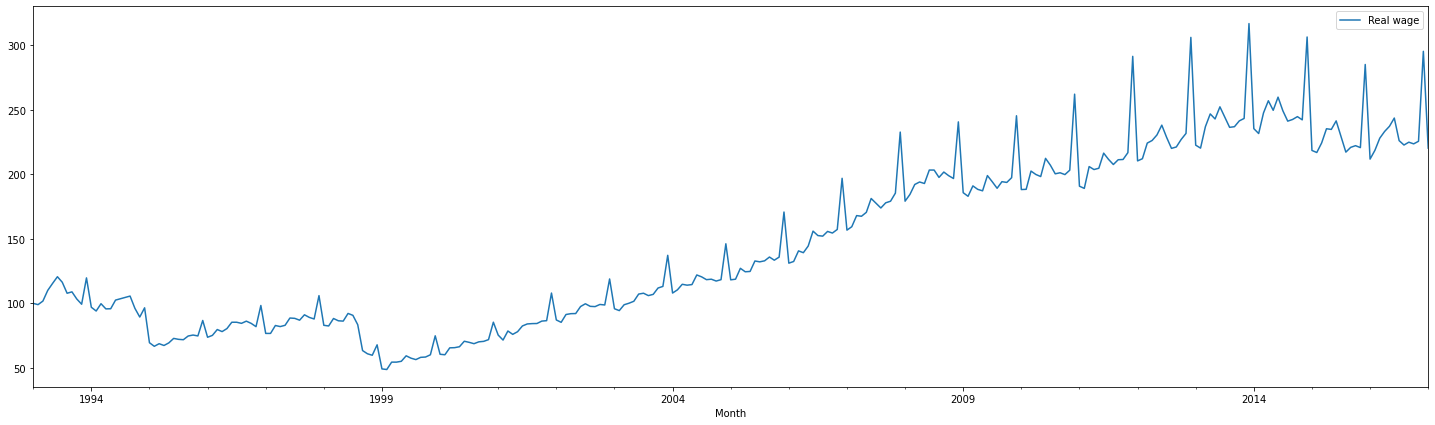

In [5]:
# Wage data in RF
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage.plot(figsize=(25,7))

## Holt Model

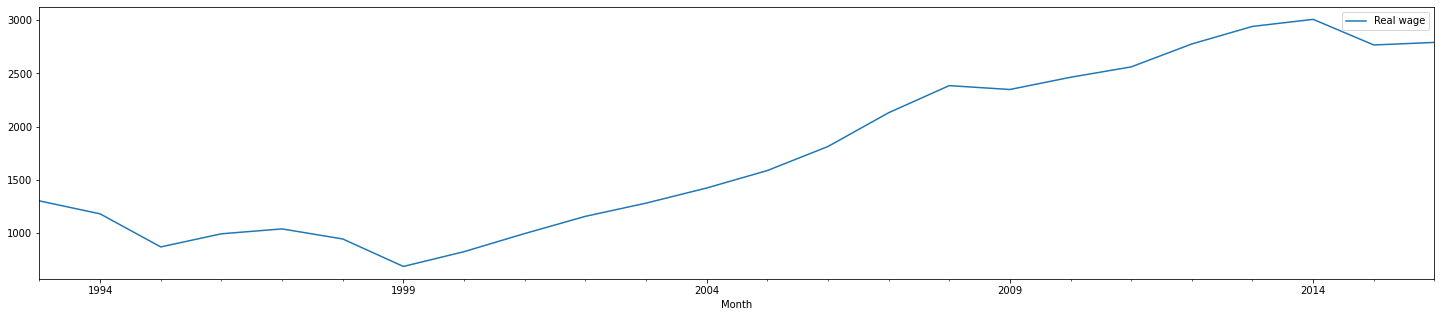

In [10]:
# Aggregate original TS by Years
wage_yare = wage.resample('12MS').sum()[:-1]
wage_yare.plot(figsize=(25,5))

In [15]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.1,1, 10)
ESparams_array = [{'alpha': alpha} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_yare, alg_name='SimpleExponentialSmoothing', alg_title='SES', params_array=ESparams_array, step='12MS')

# forecast accuracy 

In [22]:
QualitySTR = pd.DataFrame(index = wage_yare.index, columns = FRC_WAGE_YEAR.keys())
ix = wage_yare.loc['2010-01':'2018-01'].index
for cntr in sorted(QualitySTR.columns):
    frc_wage = FRC_WAGE_YEAR[cntr]
    QualitySTR[cntr], _ = qualityMAPE(wage_yare.loc[ix], frc_wage.loc[ix])

MAPE: Real wage    0.088797
dtype: float64


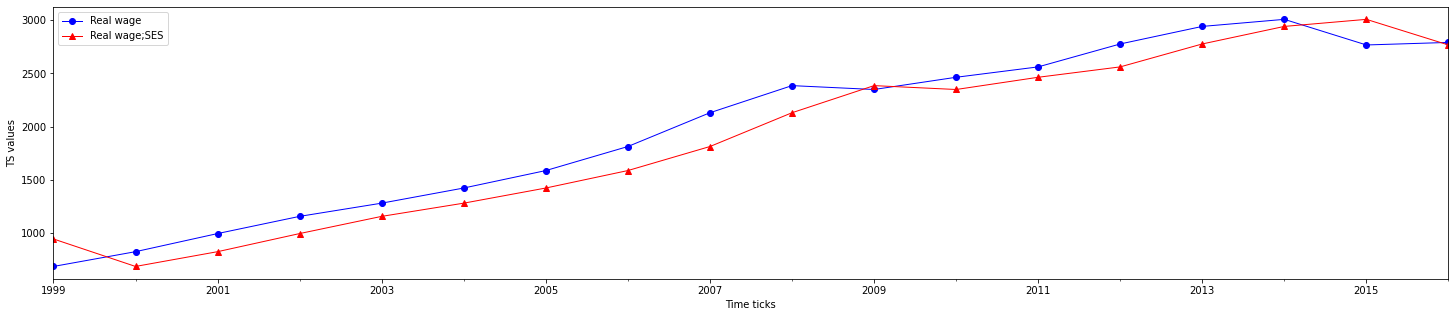

In [28]:
# Draw forecast of the best SES algorithm
alg_name = QualitySTR[QualitySTR.columns].mean().sort_values().index[0]
plot_ts_forecast(ts=wage_yare.loc['1999-01-01':'2016-01-01'], frc_ts=FRC_WAGE_YEAR[alg_name].loc['1999-01-01':'2016-01-01'], ts_num=0, alg_title='SES')
test_period_start = '2000-01-01'
test_period_end = '2016-01-01'
print('MAPE: %s' % qualityMAPE(wage_yare.loc[test_period_start:test_period_end], FRC_WAGE_YEAR[alg_name].loc[test_period_start:test_period_end])[0])

In [31]:
from re import L
###################### Holt Exponential Smoothing #########################
# x - time series, 
# h  - forecasting delay
# Params  - dictionary with 
#    alpha  - smoothing parameter
#    beta  - linear trend smoothing parameter
#    

def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    # l, b - features of TS l-level, b-trend
    l = np.NaN
    b = np.NaN

    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1] - x[t]
                t0 = np.NaN

            l_prev = l
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)(t-t0+1)/(AdaptationPeriod)*(l-l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha * x[t] + (1-alpha)*(l+b)
                b = beta*(l-l_prev) + (1-beta)*b

        FORECAST[t+h] = l + h*b
    return FORECAST

MAPE: Real wage    0.06872
dtype: float64


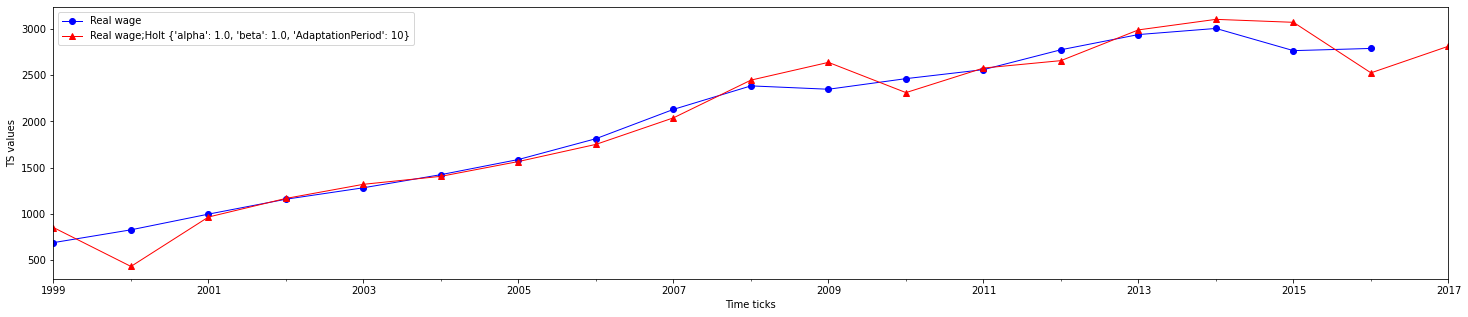

In [32]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
BETA = np.linspace(0.01,1,10)

holt_params_array = [{'alpha':alpha, 'beta':beta, 'AdaptationPeriod':10} for alpha in ALPHA for beta in BETA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_yare, alg_name =  'HoltExponentialSmoothing', alg_title='Holt'
                              ,params_array = holt_params_array, step='12MS')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = wage_yare.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_yare.loc['2000-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_yare.loc[ix], frc_wage.loc[ix])

# # Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage_yare.loc['1999-01-01':'2018-01-01'], FRC_WAGE_YEAR[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=0, alg_title=alg_name)

print('MAPE: %s' % qualityMAPE(wage_yare.loc[test_period_start:test_period_end], FRC_WAGE_YEAR[alg_name].loc[test_period_start:test_period_end])[0])

## Winters Model

In [46]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/seasonal_ts.csv', parse_dates=['Dates'], sep=';', dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
Timestamp,,,,,,,,,,
2006-01-01,0,49,64,70.468,0,45.182,71,21.664,138,0
2006-01-02,0,56,60,57.368,0,39.506,27,19.664,76,6
2006-01-03,0,61,71,34.350,0,28.064,10,10.402,152,12
2006-01-04,0,32,59,40.186,0,40.256,27,9.938,67,12
2006-01-05,0,45,61,28.914,0,35.784,27,16.672,49,24


In [47]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
Timestamp,,,,,,,,,,
2007-01-01,156,135,64,95.925,68,57.934,30,28.854,19,0
2007-01-02,138,117,62,43.775,63,52.693,19,24.478,14,18
2007-01-03,148,98,67,50.750,57,43.406,15,15.704,18,6
2007-01-04,147,86,67,54.020,47,53.018,9,21.846,15,6
2007-01-05,146,124,71,50.400,59,74.212,15,33.082,2,12


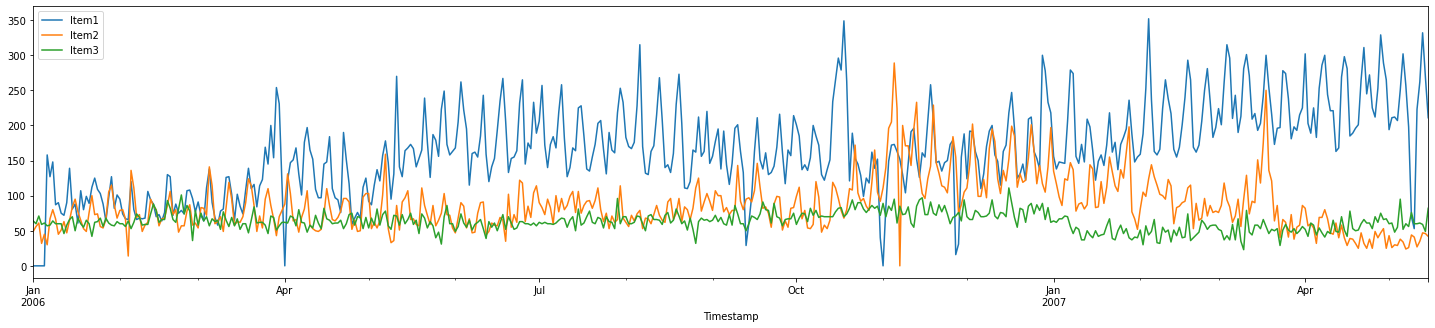

In [48]:
ts.loc['2005-07-01':'2007-12-31', ts.columns[range(3)]].plot(figsize=(25,5))

**Additive Winters Model = Additive Seasonality**

$s_t$ -season parametr component of period $p$ - seasonly period

Forcasting Model:

$\hat y_{t+d} = \hat l_t + \hat s_{t+(d mod p) - p}$;

$\hat l_t = α(y_t - \hat s_{t-p} + (1-α)(\hat l_{t-1}))=\hat l_{t-1} + αe_t$;

$\hat s_t = \gamma(y_t - \hat l_t) + (1-\gamma)\hat s_{t-p} = \hat s_{t-p} + \gamma(1-α)e_t$


In [72]:
def AdditiveWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                # looking in the future
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*l # recurrent smoothing of level 
                
        FORECAST[cntr+h] = l + s[cntr+h-(1+h//p)*p]

    return FORECAST

MAPE: Item1     0.217423
Item2     0.272668
Item3     0.219731
Item4     0.230666
Item5     0.326965
Item6     0.335239
Item7     0.468515
Item8     0.389832
Item9     6.240275
Item10    0.756607
dtype: float64


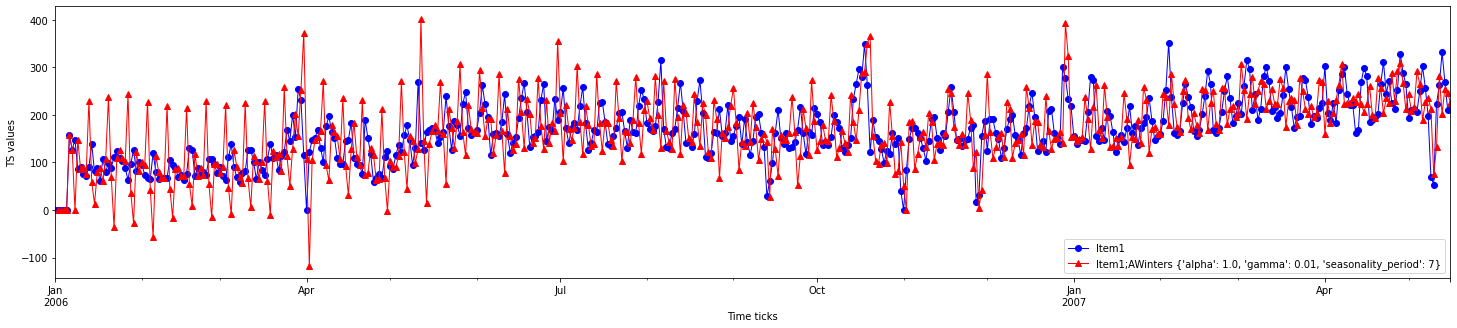

In [58]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
GAMMA = np.linspace(0.001, 0.01, 10)

wint_params_array = [{'alpha':alpha, 'gamma':gamma, 'seasonality_period':7} for alpha in ALPHA for gamma in GAMMA]
FRC_SEAS_TS = build_forecast(h=1, ts=ts, alg_name =  'AdditiveWintersExponentialSmoothing', alg_title='AWinters'\
                              ,params_array = wint_params_array, step='D')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = ts.columns, columns = FRC_SEAS_TS.keys())

ix = ts.loc['2006-01-01':'2007-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_SEAS_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(ts.loc[ix], frc_wage.loc[ix])

# # Draw forecast of the best algorithm (mean on all ts)
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(ts.loc[:], FRC_SEAS_TS[alg_name].loc[:]
               , ts_num=0, alg_title=alg_name)

test_period_start = '2007-01-01'
test_period_end = '2007-06-01'
print('MAPE: %s' % qualityMAPE(ts.loc[test_period_start:test_period_end], FRC_SEAS_TS[alg_name].loc[test_period_start:test_period_end])[0])

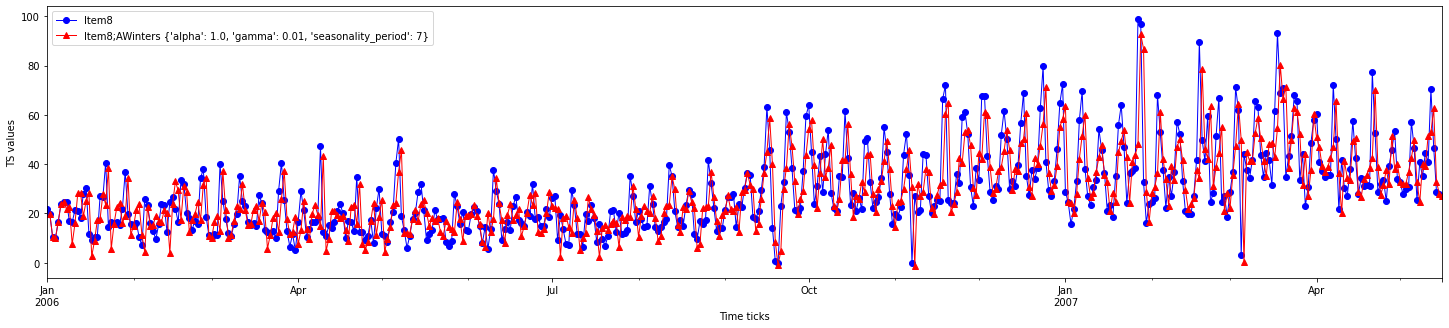

In [59]:
plot_ts_forecast(ts.loc['1999-01-01':'2018-01-01'], FRC_SEAS_TS[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=7, alg_title=alg_name)

In [ ]:
QualityStr

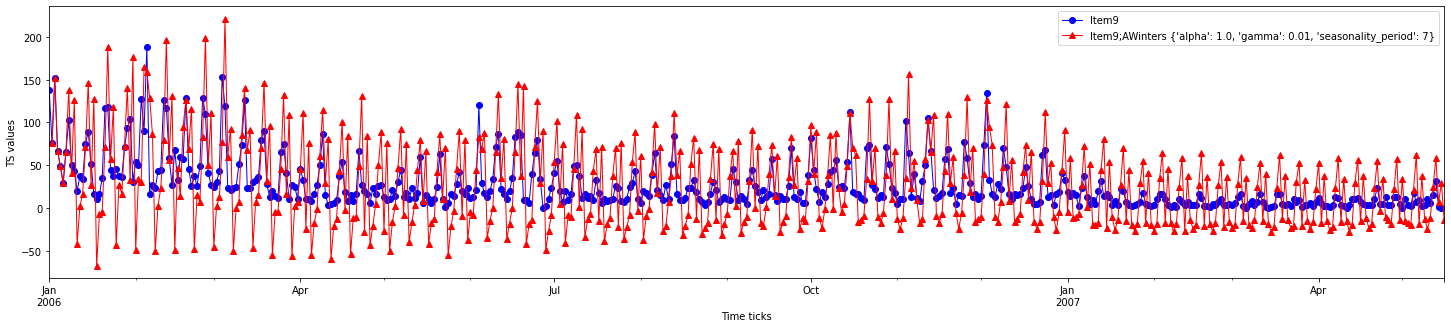

In [68]:
# the best algorithm for Item9
alg_name = QualityStr.loc[QualityStr.index[7]].sort_values().index[0]
plot_ts_forecast(ts, FRC_SEAS_TS[alg_name], ts_num=8, alg_title=alg_name)

## Theil-Wage Model

Questions

How to consider both additive trend and additive seasonality?

In [69]:
###################### Winters Exponential Smoothing #########################
# x - time series, 
# h  - forecasting delay
# Params  - dictionary with 
#    alpha  - level smoothing parameter
#    beta  - trend smoothing parameter
#    gamma  - seasonality smoothing parameter

def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
                    
                    
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
            
        FORECAST[cntr+h] = l+b + s[cntr+h - (1+h//p)*p]
    return FORECAST

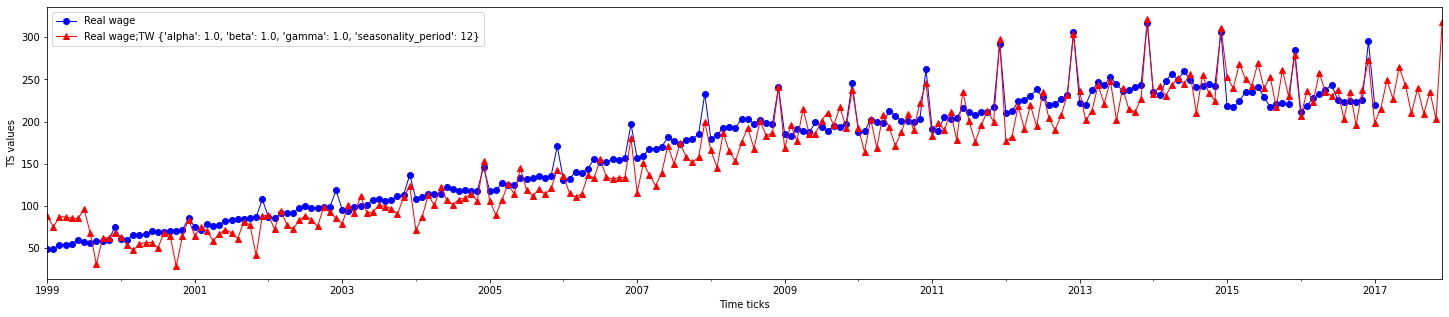

In [71]:
# TW Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
BETA = np.linspace(0.01,1,10)
GAMMA = np.linspace(0.01,1,10)

tw_params_array = [{'alpha':alpha, 'beta':beta, 'gamma':gamma, 'seasonality_period':12} for alpha in ALPHA for gamma in GAMMA for beta in BETA]
FRC_TREND_SEAS_TS = build_forecast(h=12, ts=wage, alg_name =  'TheilWageExponentialSmoothing', alg_title='TW'\
                              ,params_array = tw_params_array, step='M')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_TREND_SEAS_TS.keys())

ix = wage.loc['2010-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc = FRC_TREND_SEAS_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage.loc[ix], frc.loc[ix])

# # Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage.loc['1999-01-01':'2018-01-01'], FRC_TREND_SEAS_TS[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=0, alg_title=alg_name)

# test_period_start = '2015-01-01'
# test_period_end = '2018-01-01'
# print('MAPE: %s' % qualityMAPE(wage.loc[test_period_start:test_period_end], FRC_TREND_SEAS_TS[alg_name].loc[test_period_start:test_period_end])[0])
     

# Exponential Smoothing Models Family



1.   Multiplicative trend model
2.   Damp-trend model
3.   Multiplicative Seasonality or Multiplicative Trend

